In [1]:
import numpy as np 
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold,KFold,train_test_split
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt

import datetime
import random
from operator import itemgetter
import time
import copy

from scipy.io import mmread

In [2]:
dtrain = (mmread('writemm_sparse/dtrain_sparse')).tocsr()
dtest = (mmread('writemm_sparse/dtest_sparse')).tocsr()

act_train_data = pd.read_csv("redhat_data_new/act_train_new_try2.csv",dtype={'people_id': np.str, 'activity_id': np.str, 'outcome': np.int8}, parse_dates=['date'])
act_test_data  = pd.read_csv("redhat_data_new/act_test_new_try2.csv", dtype={'people_id': np.str, 'activity_id': np.str}, parse_dates=['date'])
people_data    = pd.read_csv("redhat_data_new/people.csv", dtype={'people_id': np.str, 'activity_id': np.str, 'char_38': np.int32}, parse_dates=['date'])

In [3]:
act_test_data['outcome'] = pd.Series([0.5]*(act_test_data.shape[0]))
train_data = pd.concat([act_train_data, act_test_data], ignore_index=True)
print('All features: train_data shape {}'.format(train_data.shape))

All features: train_data shape (2695978, 15)


In [4]:
from scipy.sparse import csr_matrix, hstack, vstack
Xtrain = vstack((dtrain, dtest), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (2695978, 14140)


In [5]:
y1 = [0]*(dtrain.shape[0])
y2 = [1]*(dtest.shape[0])
y = pd.Series(y1 + y2)
from sklearn.preprocessing import LabelEncoder
targetencoder = LabelEncoder().fit(y.values)
y = targetencoder.transform(y.values)
nclasses = len(targetencoder.classes_)

In [6]:
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain = max_abs_scaler.fit_transform(Xtrain)

In [44]:
from sklearn.cross_validation import LabelKFold
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
np.random.seed(333)
lkf = LabelKFold(train_data['people_id'], n_folds=5)

NameError: name 'train_data' is not defined

In [43]:
def score(clf, random_state = 23):
    #lkf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in lkf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(roc_auc_score(yte, pred[itest,1:])), end=' ')
        #return roc_auc_score(yte, pred[itest, 1:])
    
    print("score : {:.5f}".format(roc_auc_score(y, pred[:,1:])), end=' ')
    return roc_auc_score(y, pred[:,1:])

[  1.00000000e-04   2.78255940e-04   7.74263683e-04   2.15443469e-03
   5.99484250e-03   1.66810054e-02   4.64158883e-02   1.29154967e-01
   3.59381366e-01   1.00000000e+00]
folc score 0.89392 folc score 0.89470 folc score 0.89728 folc score 0.90084 folc score 0.90364 folc score 0.90715 folc score 0.90868 folc score 0.91294 folc score 0.91435 folc score 0.91518 

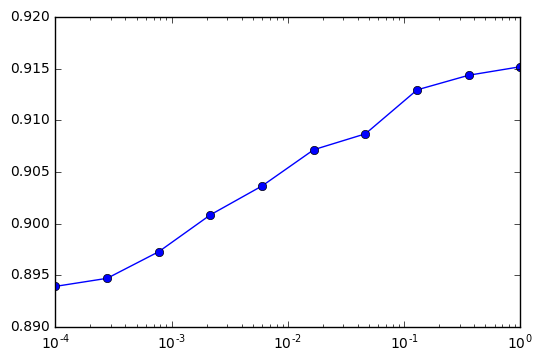

In [31]:
Cs = np.logspace(-4,0,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, class_weight='balanced', solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [42]:
import gc
#del train_data
del act_train_data
del act_test_data
del people_data
gc.collect()

18157

[    1.             2.15443469     4.64158883    10.            21.5443469
    46.41588834   100.           215.443469     464.15888336  1000.        ]
0.91518 0.91495 0.91593 0.91718 0.91634 0.91480 0.91651 0.91611 0.91475 0.91421 

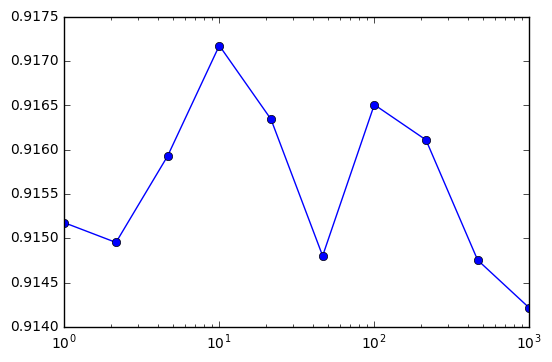

In [34]:
Cs = np.logspace(0,3,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, class_weight='balanced', solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [40]:
roc_auc_score(y, pd.Series([0.]*(Xtrain.shape[0])))

0.5

In [46]:
'''
Cs = np.linspace(9,12,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, class_weight='balanced', solver='lbfgs', n_jobs=-1)))
plt.plot(Cs, res,'-o');
'''

"\nCs = np.linspace(9,12,10)\nprint(Cs)\nres = []\nfor C in Cs:\n    res.append(score(LogisticRegression(C = C, class_weight='balanced', solver='lbfgs', n_jobs=-1)))\nplt.plot(Cs, res,'-o');\n"